In [1]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score


from xgboost import XGBClassifier

# argument parsing 
#parser = argparse.ArgumentParser(description='Process some integers.')
#parser.add_argument('integers', metavar='N', type=int, nargs='+',
#                   help='an integer for the accumulator')
#parser.add_argument('--sum', dest='accumulate', action='store_const',
#                   const=sum, default=max,
#                   help='sum the integers (default: find the max)')

#args = parser.parse_args()
#idx_lr = sys.argv[1]
idx_lr = 1
#idx_md = sys.argv[2]
idx_md = 1

# set seed 
rng = np.random.RandomState(1)

# set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")



In [2]:
# list of desired DDI Types
desired_DDI = [0, # safe
               #4, # The metabolism of #Drug2 can be increased when combined with #Drug1.
               #6, # Drug1 may increase the anticoagulant activities of #Drug2.
               15, # Drug1 may increase the cardiotoxic activities of #Drug2.
               16, # Drug1 may increase the central nervous system depressant (CNS depressant) activities of #Drug2.
               18, # Drug1 can cause an increase in the absorption of #Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.
               20, # Drug1 may increase the QTc-prolonging activities of #Drug2.
               32, # Drug1 may increase the sedative activities of #Drug2.
               54, # Drug1 may increase the bradycardic activities of #Drug2.
               72, # Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.
               76, # Drug1 may decrease the sedative activities of #Drug2.
               80  # Drug1 may increase the hepatotoxic activities of #Drug2.
              ]


# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# load the data 
ddidata = pd.read_excel("DrugBank_known_ddi.xlsx")
interactiondict = pd.read_csv("Interaction_information.csv")
safe_drugs = pd.read_csv("safe_drug_combos.csv")
drug_similarity_feature = pd.read_csv("drug_similarity.csv")
drug_similarity = drug_similarity_feature.iloc[:, 1:len(drug_similarity_feature)+1]

# filter ddidata for desired DDI types
up_ddidata = ddidata[ddidata.Label.isin(desired_DDI)]
new_ddidata = up_ddidata.copy()

# convert types to int
new_ddidata.drug1 = up_ddidata.drug1.str[2:].astype(int)
new_ddidata.drug2 = up_ddidata.drug2.str[2:].astype(int)
new_ddidata.Label = up_ddidata.Label


# incorporate safe_drugs into new_ddidata with DDIType 0
safe_drugs["Label"] = 0

frames = [safe_drugs, new_ddidata]
ddi_df = pd.concat(frames)

# create a DB to index dictionary from similarity dataset
DB_to_index = {}
i = 0
for col in drug_similarity.columns:
    DB_to_index[int(col[2:7])] = i
    i = i + 1

# filter output to only include DBs with similarity features
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

# filter out the duplicate samples
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]


# feature building 
# add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec
    
# create input and output vectors for training

X_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
#                                                                           , random_state = 1)
#X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
#                                                                       , random_state = 1)

# dmatrix


INFO: iter 1
INFO: iter 10001
INFO: iter 20001


In [4]:
X_data[1:5, :]

array([[0.193  , 0.2646 , 0.1102 , ..., 0.0758 , 0.2491 , 0.04837],
       [0.193  , 0.2646 , 0.1102 , ..., 0.0763 , 0.2952 , 0.07074],
       [0.1964 , 0.3    , 0.161  , ..., 0.1316 , 0.1349 , 0.0367 ],
       [0.1968 , 0.2426 , 0.1144 , ..., 0.11536, 0.261  , 0.06415]],
      dtype=float16)

(array([ 255.,  330., 1288., 1258.,  708.,  305.,  112.,   44.,   12.,
           6.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float16), <a list of 10 Patch objects>)

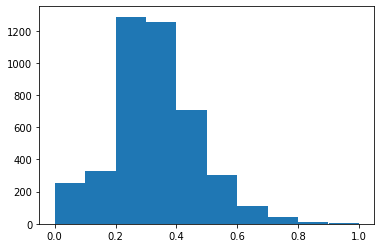

In [5]:
plt.hist(X_data[1,:])

(array([8.5300e+02, 2.5300e+03, 1.1591e+04, 1.0569e+04, 1.5880e+03,
        3.4800e+02, 1.0500e+02, 1.0000e+00, 1.0000e+00, 8.9000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float16),
 <a list of 10 Patch objects>)

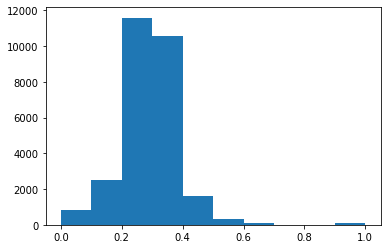

In [6]:
plt.hist(X_data[:,1])

In [7]:
X_data.shape

(27675, 4318)

In [8]:
y_data.shape

(27675,)

In [3]:
bst


,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.233878,0.003391,2.618907,0.00159,0.237205,0.004361,2.62549,0.002341


In [5]:



# testing
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# save the object 
print("----- INFO: saving results -----")
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/cv_output/"
history_path = output_dir + "_lr_" + learning_rate + "_md_" + max_depth + "_history_dict.pickle"
model_path = output_dir + "_lr_" + learning_rate + "_md_" + max_depth + "_xgb.pickle"
pickle.dump(history_dict, history_path)
pickle.dump(bst, model_path)



TypeError: cv() got an unexpected keyword argument 'evals'

In [19]:
param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    'verbosity': 3,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 43}  # the number of classes that exist in this datset
num_round = 1  # the number of training iterations

history_dict = {}
bst = xgb.train(param, 
                dtrain, 
                num_round,
                early_stopping_rounds = 5,
                evals = [(dval, 'validation'), (dtest,'test'), (dtrain,'train')],
                #evals = [(dtest,'test'), (dtrain,'train')],
                evals_result = history_dict
                )



# testing
#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])
#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])

# save the object 
print("----- INFO: saving results -----")
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output/"
history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
model_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_xgb.pickle"
history_fo = open(history_path, "wb")
model_fo = open(model_path, "wb")
pickle.dump(history_dict, history_fo)
pickle.dump(bst, model_fo)
history_fo.close()
model_fo.close()


[19:39:33] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[19:39:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:39:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:39:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:39:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[19:40:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:40:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:40:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[19:40:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 6 extra node

In [ ]:
# collect the results

### networkx 

In [23]:
import networkx as nx

In [10]:
networkx.__version__

'2.3'

In [11]:
ddi_clean.shape

(27675, 3)

In [14]:
type(ddi_clean)

pandas.core.frame.DataFrame

In [17]:
drug_list = np.unique(pd.concat([ddi_clean.drug1, ddi_clean.drug2]))

In [21]:
len(drug_list)
drug_list[:6]

array([ 14,  35,  91, 104, 121, 126])

##### building the graph 

In [24]:
G = nx.Graph()
G.add_nodes_from(drug_list)

In [27]:
ddi_clean.head()

,drug1,drug2,Label
0,956,316,0
1,977,717,0
2,977,957,0
3,1060,766,0
4,1395,977,0


In [30]:
ddi_clean[ddi_clean.drug2 == 977]

,drug1,drug2,Label
4,1395,977,0
5,367,977,0
8,304,977,0
10,294,977,0
153983,2659,977,72


In [41]:
drug_pair_list = list(zip(list(ddi_clean.drug1), list(ddi_clean.drug2)))

In [42]:
G.add_edges_from(drug_pair_list)

In [44]:
print(G.number_of_nodes())
print(G.number_of_edges())

1115
27675


In [49]:
nx.draw_shell()

Object `nx.draw_shell()` not found.


In [52]:
np.unique(list(drug_pair_list[0]))

array([316, 956])

In [53]:
from networkx.algorithms.community import greedy_modularity_communities

In [54]:
res_communities = greedy_modularity_communities(G)


In [55]:
c = list(res_communities)

In [156]:
len(res_communities)

9

In [59]:
!pwd

/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/data


In [60]:
from matplotlib import pylab

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph.pdf")

/home/zy92/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


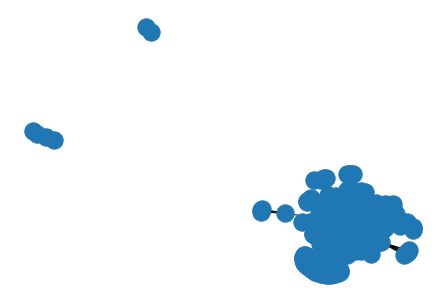

In [62]:
nx.draw(G)

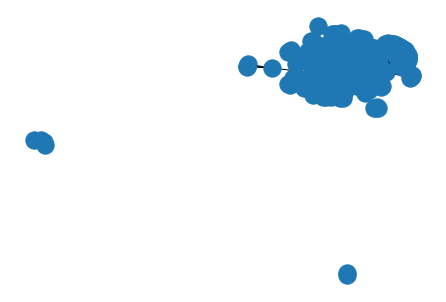

In [63]:
nx.draw(G,pos=nx.spring_layout(G))

/home/zy92/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


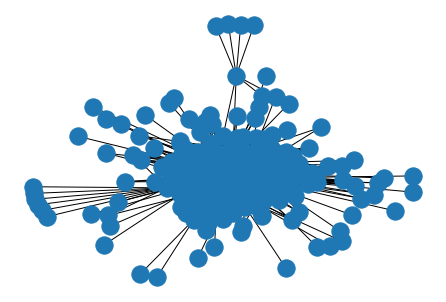

In [65]:
G1 = G.subgraph(res_communities[0])
nx.draw(G1,pos=nx.spring_layout(G1))

In [69]:
a = [1,3] + [4,6]
a

[1, 3, 4, 6]

In [72]:
type(res_communities[1])

frozenset

In [73]:
type(res_communities)

list

In [74]:
len(list(res_communities[1]) + list(res_communities[2]))

485

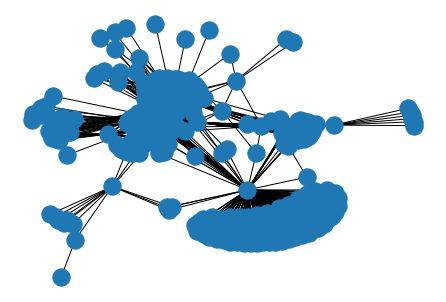

In [76]:
G2 = G.subgraph(list(res_communities[1]) + list(res_communities[2]) + list(res_communities[3]))
nx.draw(G2,pos=nx.spring_layout(G2))

In [77]:
pos = nx.spring_layout(G) # positions for all nodes

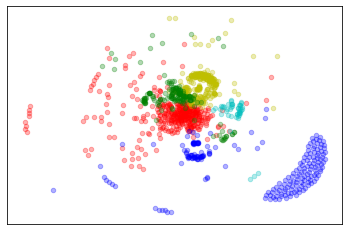

In [96]:
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[0],
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[1],
                       node_color='y',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[2],
                       node_color='b',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[3],
                       node_color='g',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[4],
                       node_color='c',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(res_communities[5]),
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[6]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[7]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=list(res_communities[8]),
#                        node_color='r',
#                        node_size=20,
#                    alpha=0.3)


In [84]:
[len(x) for x in res_communities]

[393, 263, 222, 171, 48, 8, 4, 4, 2]

In [160]:
type(G.edges())

networkx.classes.reportviews.EdgeView

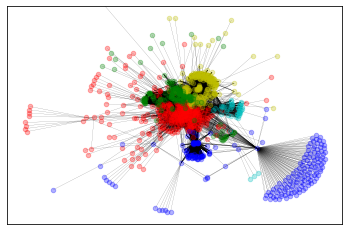

In [162]:
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[0],
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[1],
                       node_color='y',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[2],
                       node_color='b',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[3],
                       node_color='g',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=res_communities[4],
                       node_color='c',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(res_communities[5]),
                       node_color='r',
                       node_size=20,
                   alpha=0.3)
nx.draw_networkx_edges(G, pos=pos, width = 0.1)

In [128]:
import pickle
file_Name = "community_ddi.pickle"
# open the file for writing
fileObject = open(file_Name, 'wb')
pickle.dump(res_communities,fileObject)
fileObject.close()

In [132]:
len(res_communities[2])

222

In [129]:
test_idx = ddi_clean.drug1.isin(res_communities[2]) | ddi_clean.drug2.isin(res_communities[2]) 
ddi_df_test = ddi_clean[test_idx]
ddi_df_train = ddi_clean[~test_idx]


In [130]:
ddi_df_test.shape

(1824, 3)

In [131]:
ddi_df_train.shape

(25851, 3)

In [133]:
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

In [134]:
X_train = X_data[~test_idx]
X_test = X_data[test_idx]
y_train = y_data[~test_idx]
y_test = y_data[test_idx]
X_train.shape

(25851, 4318)

In [137]:
dtrain = xgb.DMatrix(X_data, label = y_data)
dtest = xgb.DMatrix(X_test, label = y_test)
#dval = xgb.DMatrix(X_val, label = y_val)

print("----- INFO: training data preprocess is done. -----")
# param
max_depth = parameters["max_depth"][idx_md]
learning_rate = parameters["learning_rate"][idx_lr]


param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    #'verbosity': 3,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 10}  # the number of classes that exist in this datset
num_round = 10 # the number of training iterations

print("----- INFO: XGBoost Parameters -----")
print(param)

----- INFO: training data preprocess is done. -----
----- INFO: XGBoost Parameters -----
{'max_depth': 4, 'learning_rate': 0.1, 'eta': 0.3, 'objective': 'multi:softprob', 'eval_metric': ['merror', 'mlogloss'], 'num_class': 10}


In [138]:
history_dict = {}
bst_split = xgb.train(param, 
                dtrain, 
                num_round,
                early_stopping_rounds = 5,
                evals = [(dtrain,'train'), (dtest,'test')],
                #evals = [(dtest,'test'), (dtrain,'train')],
                evals_result = history_dict,
                verbose_eval = 1
                )

[10:29:12] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[10:29:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[10:29:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[10:29:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:29:37] ======== Monitor: Learner ========
[10:29:37] Configure: 0.001924s, 1 calls @ 1924us

[10:29:37] EvalOneIter: 0.091405s, 10 calls @ 91405us

[10:29:37] GetGradient: 0.084411s, 10 calls @ 84411us

[10:29:37] PredictRaw: 1.49636s, 10 calls @ 1496358us

[10:29:37] UpdateOneIter: 247.291s, 10 calls @ 247291315us

[10:29:37] ======== Monitor: GBTree ========
[10:29:37] BoostNewTrees: 223.263s, 10 calls @ 223263371us

[10:29:37] CommitModel: 22.4441s, 10 calls @ 22444118us

[10:29:37] ======== Monitor: Learner ========
[10:29:37] Configure: 1e-06s, 1 calls 

KeyboardInterrupt: 

[10:29:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:29:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[10:29:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4


KeyboardInterrupt: 

KeyboardInterrupt: 

[10:30:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-merror:0.21677	train-mlogloss:2.01572	test-merror:0.01590	test-mlogloss:1.86696
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[10:30:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:30:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[10:30:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:30:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[10:30:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[10:30:26] INFO: /workspace/src/tree/updat

In [142]:
bst_split

### plotting 

In [153]:
!pwd

/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/data


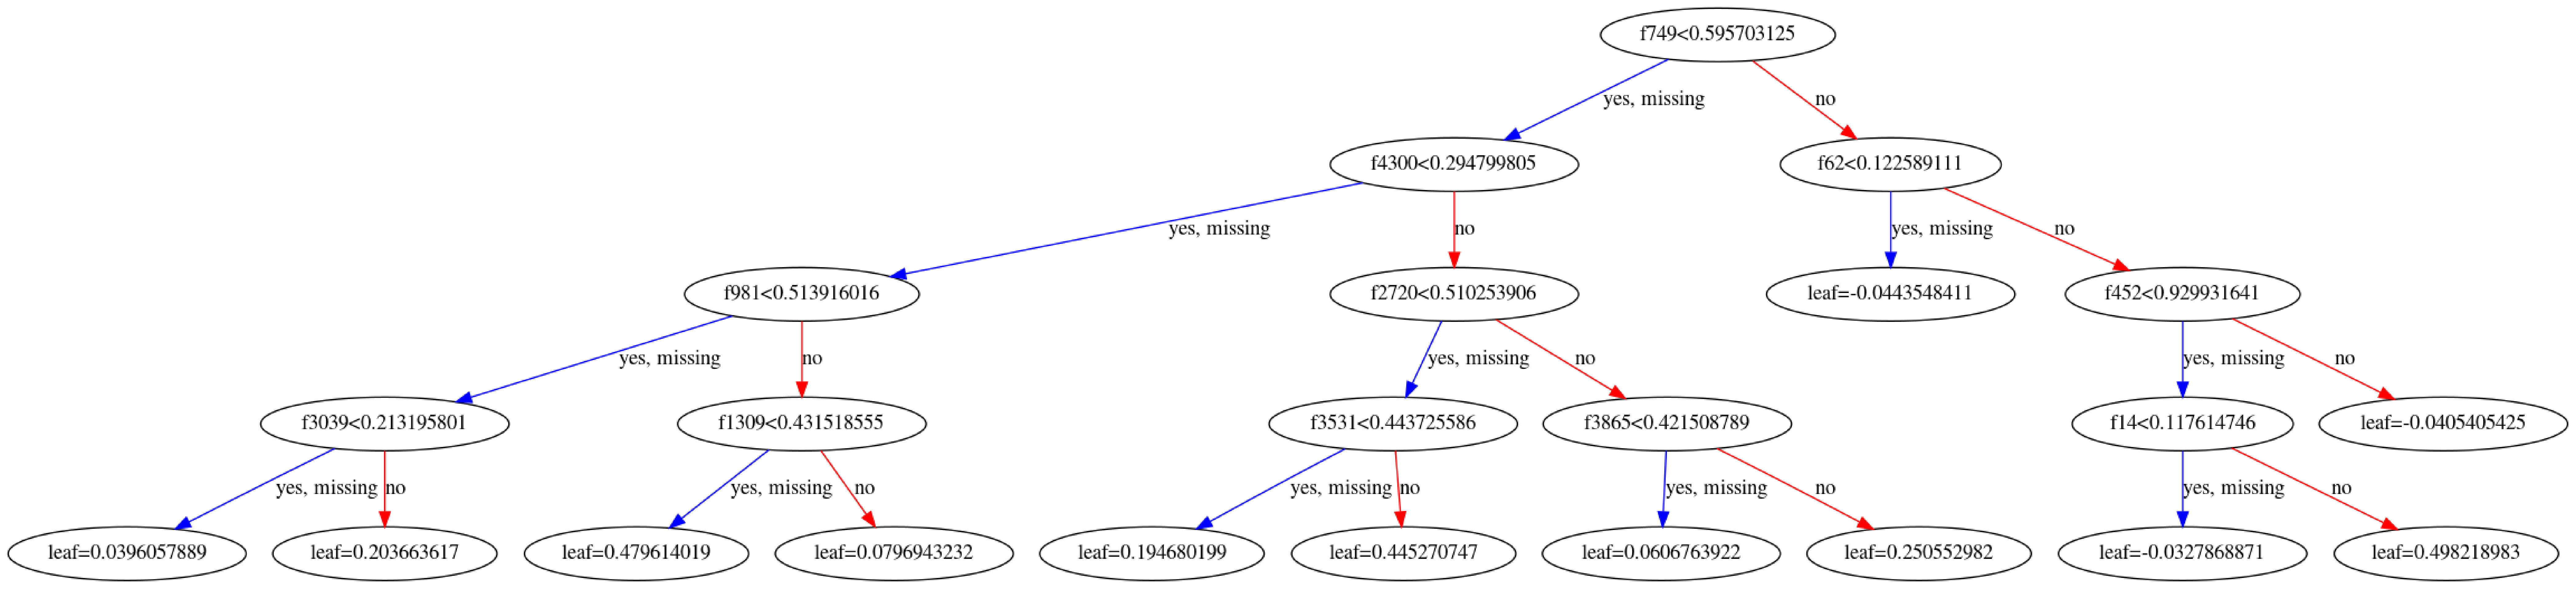

In [155]:
import graphviz
from xgboost import plot_tree
import matplotlib

plot_tree(bst_split)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree_smiles.png')

In [146]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} graphviz

Solving environment: done

## Package Plan ##

  environment location: /home/zy92/anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         2.8 MB
    graphviz-2.40.1            |       h21bd128_2         6.5 MB
    ------------------------------------------------------------
                                           Total:         9.3 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/linux-64::graphviz-2.40.1-h21bd128_2

The following packages will be UPDATED:

  conda                                        4.8.1-py37_0 --> 4.8.3-py37_0



graphviz-2.40.1      | 6.5 MB    | ##################################### | 100% 
conda-4.8.3          | 2.8 MB    | ##################################### | 100% 

InvalidArchiveError("Error with archive /gpfs/ysm/project/zh

In [147]:
import sys
sys.path

['/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/code/xgboost',
 '/home/zy92/anaconda3/lib/python37.zip',
 '/home/zy92/anaconda3/lib/python3.7',
 '/home/zy92/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/zy92/anaconda3/lib/python3.7/site-packages',
 '/home/zy92/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/gpfs/ysm/home/zy92/.ipython']

In [148]:
import graphviz

In [110]:
history_list


,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.210298,0.005948,2.016191,0.001178,0.217453,0.001457,2.018391,0.001515
1,0.136947,0.000452,1.801880,0.001927,0.146305,0.004451,1.806474,0.001601
2,0.121066,0.003474,1.632245,0.002663,0.131888,0.002112,1.639116,0.001202
3,0.110768,0.003477,1.494462,0.002919,0.121373,0.004776,1.502799,0.001456
4,0.103288,0.000982,1.378172,0.003740,0.113568,0.005499,1.388180,0.002482
5,0.092900,0.002361,1.273003,0.002287,0.102439,0.005892,1.284172,0.004305
6,0.087299,0.001758,1.183210,0.001526,0.096477,0.005716,1.195453,0.004203
7,0.080000,0.003992,1.100019,0.002867,0.089033,0.006313,1.113129,0.007371
8,0.073315,0.002601,1.026729,0.002517,0.082638,0.004788,1.040269,0.006068
9,0.068419,0.002167,0.957578,0.002112,0.078518,0.004053,0.971995,0.005733


In [114]:
print(dtrain.num_row

<bound method DMatrix.num_row of <xgboost.core.DMatrix object at 0x2af7ac987610>>


In [118]:
param = {
    'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': learning_rate,
    'eta': 0.3,  # the training step for each iteration
    #'silent': 3,  # logging mode - quiet
    'verbosity': 2,  # debug mode
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 43}  # the number of classes that exist in this datset
num_round = 50  # the number of training iterations

# training
history_dict = {}
bst = xgb.train(param, 
                dtrain, 
                num_round,
                early_stopping_rounds = 5,
                evals = [(dtrain,'train'), (dtest,'test')],
                evals_result = history_dict
               )

[23:17:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:17:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[23:17:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:17:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:17:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:17:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:17:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:17:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:17:45] INFO: /workspace/src/tree/upda

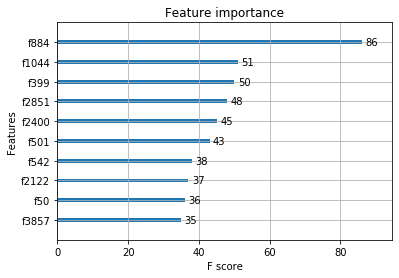

In [166]:
from xgboost import plot_importance
plot_importance(bst_split, max_num_features=10,) # top 10 most important features
plt.show()




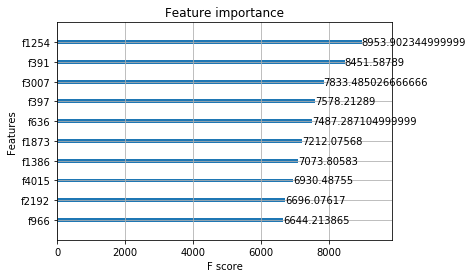

In [169]:
plot_importance(bst_split, max_num_features=10, importance_type="cover") # top 10 most important features
plt.show()



In [170]:
import pickle

file_Name = "10class_xgboost_model.pickle"
# open the file for writing
fileObject = open(file_Name,'wb')

# this writes the object a to the
# file named 'testfile'
pickle.dump(bst_split,fileObject)

# here we close the fileObject
fileObject.close()
# we open the file for reading
fileObject = open(file_Name,'rb')
# load the object from the file into var b
b = pickle.load(fileObject)

In [141]:
history_list

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.210298,0.005948,2.016191,0.001178,0.217453,0.001457,2.018391,0.001515
1,0.136947,0.000452,1.801880,0.001927,0.146305,0.004451,1.806474,0.001601
2,0.121066,0.003474,1.632245,0.002663,0.131888,0.002112,1.639116,0.001202
3,0.110768,0.003477,1.494462,0.002919,0.121373,0.004776,1.502799,0.001456
4,0.103288,0.000982,1.378172,0.003740,0.113568,0.005499,1.388180,0.002482
5,0.092900,0.002361,1.273003,0.002287,0.102439,0.005892,1.284172,0.004305
6,0.087299,0.001758,1.183210,0.001526,0.096477,0.005716,1.195453,0.004203
7,0.080000,0.003992,1.100019,0.002867,0.089033,0.006313,1.113129,0.007371
8,0.073315,0.002601,1.026729,0.002517,0.082638,0.004788,1.040269,0.006068
9,0.068419,0.002167,0.957578,0.002112,0.078518,0.004053,0.971995,0.005733


In [124]:
!pwd

/gpfs/loomis/pi/zhao2/zy92/projects/ddipred/ddi_pred/data


In [125]:
import numpy as np
np.savetxt("X_matrix_ddi.txt", X_data)
np.savetxt("y_ddi.txt", y_data)

In [126]:
np.savetxt("ddi.txt", ddi_clean)

In [123]:
from sklearn.linear_model import LogisticRegression
#X, y = load_iris(return_X_y=True)
clf = LogisticRegression(multi_class="multinomial", solver='lbfgs').fit(X_data, y_data)
clf.predict(X_data[:2, :])

clf.predict_proba(X_data[:2, :])


clf.score(X_data, y_data)

/home/zy92/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7726106594399277